In [ ]:
"""Dataset : https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset"""

In [2]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
data_train = pd.read_csv('hour.csv')
data_train

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [4]:
data_train.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Text(0.5, 1.0, 'Temperature')

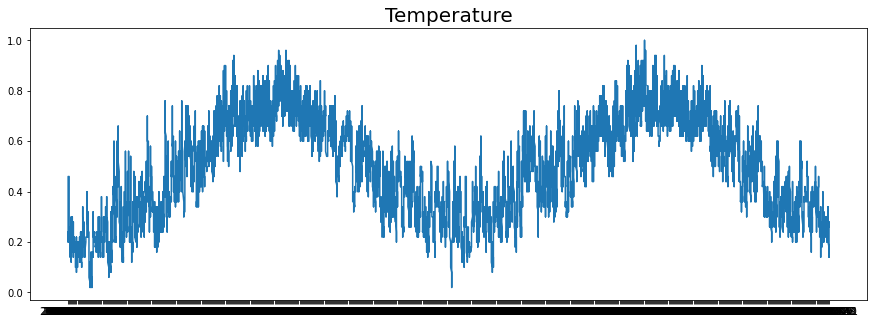

In [5]:
dates = data_train['dteday'].values
temp = data_train['temp'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature', fontsize=20)

In [17]:
from sklearn.model_selection import train_test_split
date_latih, date_test, temp_latih, temp_test = train_test_split(dates, temp, test_size=.2, shuffle=False)

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [19]:
train_set = windowed_dataset(temp_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(temp_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
   tf.keras.layers.LSTM(60, return_sequences=True),
   tf.keras.layers.LSTM(60),
   tf.keras.layers.Dense(30, activation="relu"),
   tf.keras.layers.Dense(10, activation="relu"),
   tf.keras.layers.Dense(1)
])

In [20]:
minMae = (data_train['temp'].max() - data_train['temp'].min()) * .1

print(minMae)

0.098


In [22]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae')<minMae) & (logs.get('val_mae')<minMae):
      print('\nProses dihentikan karena tingkat MAE sudah mencapai <10%!')
      self.model.stop_training = True

callbacks = myCallback()

In [24]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.000e-04, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
    )
history = model.fit(
    train_set,
    epochs=100,
    validation_data=test_set,
    verbose=2,
    callbacks=[callbacks],
    )

Epoch 1/100
139/139 - 22s - loss: 0.0563 - mae: 0.2889 - val_loss: 0.0354 - val_mae: 0.2223 - 22s/epoch - 155ms/step
Epoch 2/100
139/139 - 16s - loss: 0.0339 - mae: 0.2135 - val_loss: 0.0210 - val_mae: 0.1636 - 16s/epoch - 118ms/step
Epoch 3/100
139/139 - 18s - loss: 0.0229 - mae: 0.1746 - val_loss: 0.0144 - val_mae: 0.1376 - 18s/epoch - 129ms/step
Epoch 4/100
139/139 - 18s - loss: 0.0177 - mae: 0.1563 - val_loss: 0.0115 - val_mae: 0.1272 - 18s/epoch - 126ms/step
Epoch 5/100
139/139 - 19s - loss: 0.0154 - mae: 0.1478 - val_loss: 0.0104 - val_mae: 0.1232 - 19s/epoch - 135ms/step
Epoch 6/100
139/139 - 18s - loss: 0.0143 - mae: 0.1436 - val_loss: 0.0098 - val_mae: 0.1211 - 18s/epoch - 131ms/step
Epoch 7/100
139/139 - 19s - loss: 0.0137 - mae: 0.1411 - val_loss: 0.0096 - val_mae: 0.1201 - 19s/epoch - 140ms/step
Epoch 8/100
139/139 - 17s - loss: 0.0135 - mae: 0.1398 - val_loss: 0.0096 - val_mae: 0.1196 - 17s/epoch - 122ms/step
Epoch 9/100
139/139 - 18s - loss: 0.0133 - mae: 0.1388 - val_los

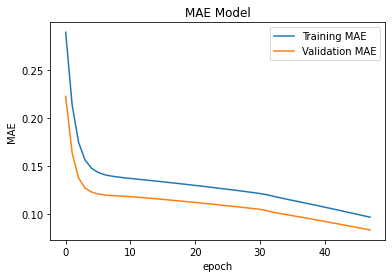

In [34]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['Training MAE', 'Validation MAE'], loc='upper right')
plt.show()

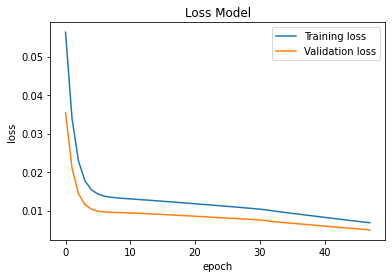

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()